# Raymond

Installs

In [ ]:
!pip install pyrender
!sudo apt update
!sudo wget https://github.com/mmatl/travis_debs/raw/master/xenial/mesa_18.3.3-0.deb
!sudo dpkg -i ./mesa_18.3.3-0.deb || true
!sudo apt install -f
!git clone https://github.com/mmatl/pyopengl.git
!pip install ./pyopengl
!git clone https://github.com/mmatl/pyrender.git
!git clone https://github.com/RayDanks/Data_Download_PointNet.git #downloading my data

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 252 kB in 1s (258 kB/s)
Reading package lists... Done
Building dependency tree       
Reading 

fatal: destination path 'pyrender' already exists and is not an empty directory.
fatal: destination path 'Data_Download_PointNet' already exists and is not an empty directory.


Imports

In [ ]:
import os
os.environ["PYOPENGL_PLATFORM"] = "osmesa"
import numpy as np
import trimesh
import pyrender



import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten, BatchNormalization, Lambda, Input
from keras.callbacks import TensorBoard
from keras.optimizers import Adam
from keras import optimizers
from keras import backend as K
from keras import Model
from collections import deque
from copy import deepcopy
import random
import numpy as np
import sys
import time
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pyrender
import tensorflow as tf
import pandas
import trimesh
import glob





# Creating my own dataset for 3D Bounding boxes


Loading mesh point clouds

Firstly we need to get the pointclouds of the meshes we are using

In [ ]:
desired_point_number = 5000

list_of_clouds = glob.glob('Data_Download_PointNet/Custom_Dataset/*.obj')
print(list_of_clouds)

unique_clouds = {}
unique_meshes = {}
for cloud_name in list_of_clouds:
  point_cloud_mesh = trimesh.load(cloud_name)
  cloud, face_index = point_cloud_mesh.sample(desired_point_number, True)

  normals = point_cloud_mesh.face_normals[face_index]


  """
  The above sample allows for all of the clouds to be the same size
  Hopefully in the future, we could use less dense clouds
  etc too and just reach the same number of points by replicating points.
  """

  new = cloud_name.split("Custom_Dataset/") 
  identifier_with_obj = new[-1]
  identifier = identifier_with_obj.split(".")
  identifier = identifier[0]

  """
  It is pertinent to move the centroid of the clouds to the
  origin, so that they can be adequately rotated
  """
  cloud_original_centroid = np.c_[[np.mean(cloud[:,0]),np.mean(cloud[:,1]),np.mean(cloud[:,2])]]

  Origin = [0,0,0]
  Movement_Vector = np.c_[Origin[0] - cloud_original_centroid[0],
                          Origin[1] - cloud_original_centroid[1],
                          Origin[2] - cloud_original_centroid[2]]


  mesh_at_origin = cloud + Movement_Vector


  #normals don't need to be translated as they're unit direction vectors
  mesh_and_normals = np.hstack((mesh_at_origin,normals))

  unique_clouds[identifier] = mesh_and_normals
  unique_meshes[identifier] = point_cloud_mesh
print(unique_clouds['cube'])


['Data_Download_PointNet/Custom_Dataset/cube.obj', 'Data_Download_PointNet/Custom_Dataset/bumpy-cube-small.obj', 'Data_Download_PointNet/Custom_Dataset/bumpy-cube.obj', 'Data_Download_PointNet/Custom_Dataset/lilium.obj', 'Data_Download_PointNet/Custom_Dataset/small_cow_manifold.obj', 'Data_Download_PointNet/Custom_Dataset/bunny.obj', 'Data_Download_PointNet/Custom_Dataset/terrain.obj', 'Data_Download_PointNet/Custom_Dataset/cow_manifold.obj', 'Data_Download_PointNet/Custom_Dataset/cow_small_manifold2.obj', 'Data_Download_PointNet/Custom_Dataset/cow.obj', 'Data_Download_PointNet/Custom_Dataset/camel.obj', 'Data_Download_PointNet/Custom_Dataset/dragon.obj']
[[-0.41029185 -0.26487502 -0.49680061  0.         -0.         -1.        ]
 [ 0.50014675  0.49292641  0.41037262  1.         -0.          0.        ]
 [ 0.13424363  0.49946963  0.46643579 -0.          1.          0.        ]
 ...
 [ 0.42146799 -0.32647892 -0.49680061  0.          0.         -1.        ]
 [-0.48412932  0.49946963 -0.04

All of these meshes originally have their axes algined to the camera
we should make a function to determine the bounding box (corners)
of these.

In [ ]:
def Find_3D_Bounding_Boxes(cloud):
  x = cloud[:,0]
  y = cloud[:,1]
  z = cloud[:,2]

  max_x = np.amax(x)
  max_y = np.amax(y)
  max_z = np.amax(z)

  min_x = np.amin(x)
  min_y = np.amin(y)
  min_z = np.amin(z)

  """
  First 4 points of bounding box are bottom 4 corners, from
  bottom left going clockwise and then the next 4
  points are from the top 4 corners, starting from top
  left going clockwise
  """

  bbox = np.zeros((8,3))

  bbox[0,:] = [min_x,min_y,min_z]
  bbox[1,:] = [min_x,max_y,min_z]
  bbox[2,:] = [max_x,max_y,min_z]
  bbox[3,:] = [max_x,min_y,min_z]

  bbox[4,:] = [min_x,min_y,max_z]
  bbox[5,:] = [min_x,max_y,max_z]
  bbox[6,:] = [max_x,max_y,max_z]
  bbox[7,:] = [max_x,min_y,max_z]

  return bbox

print(Find_3D_Bounding_Boxes(unique_clouds['cube']))

[[-0.49985325 -0.50053037 -0.49680061]
 [-0.49985325  0.49946963 -0.49680061]
 [ 0.50014675  0.49946963 -0.49680061]
 [ 0.50014675 -0.50053037 -0.49680061]
 [-0.49985325 -0.50053037  0.50319939]
 [-0.49985325  0.49946963  0.50319939]
 [ 0.50014675  0.49946963  0.50319939]
 [ 0.50014675 -0.50053037  0.50319939]]


We then use this to calculate the original bounding boxes of the clouds

In [ ]:
unique_bboxes = {}

for ID, cloud_and_normals in unique_clouds.items():
  cloud = cloud_and_normals[:,:3]
  cloud_bbox = Find_3D_Bounding_Boxes(cloud)
  unique_bboxes[ID] = cloud_bbox

print(unique_bboxes['cube'])


[[-0.49985325 -0.50053037 -0.49680061]
 [-0.49985325  0.49946963 -0.49680061]
 [ 0.50014675  0.49946963 -0.49680061]
 [ 0.50014675 -0.50053037 -0.49680061]
 [-0.49985325 -0.50053037  0.50319939]
 [-0.49985325  0.49946963  0.50319939]
 [ 0.50014675  0.49946963  0.50319939]
 [ 0.50014675 -0.50053037  0.50319939]]


Now we expand our dataset and make our system more resilient
by rotating the original meshes

In [ ]:
amount_of_angles = 50 #each mesh has this number * 3 in the dataset
angles = np.linspace(0,360,amount_of_angles) # in degrees - more intuitive
amount_of_unique_clouds = len(unique_clouds)
amount_of_overall_clouds = amount_of_angles*3*(amount_of_unique_clouds-1) #-1 for validation mesh
cloud_dataset = np.zeros((amount_of_overall_clouds,desired_point_number,6))
bbox_dataset = np.zeros((amount_of_overall_clouds,24)) #24; 8 points w/ XYZ 
#the boxes will be flattened so that they can be found regressively


print(cloud_dataset.shape)
print(bbox_dataset.shape)

validation_mesh_ID = 'camel'
validation_dataset = np.zeros((amount_of_angles*3,desired_point_number,6))
validation_bbox_labels = np.zeros((amount_of_angles*3,24))

print(validation_dataset.shape)
print(validation_bbox_labels)

tracker = 0 #tracks how many clouds
val_tracker = 0 #validation tracker

#x rotations

for ID, cloud_and_normals in unique_clouds.items():
  cloud = cloud_and_normals[:,:3]
  normals = cloud_and_normals[:,3:] #we must rotate the normals too...
  original_bbox = unique_bboxes[ID]
  for a in angles:
    a = np.deg2rad(a)
    x_rot_mat = np.array(([1,0,0],[0,np.cos(a),-np.sin(a)],[0,np.sin(a),np.cos(a)]))
    
    rotated_cloud = np.dot(cloud,x_rot_mat.T)
    rotated_normals = np.dot(normals,x_rot_mat.T)
    rotated_bbox = np.dot(original_bbox, x_rot_mat.T)

    rotated_cloud_and_normals = np.hstack((rotated_cloud,rotated_normals))
    if ID == validation_mesh_ID:
      val_tracker += 1
      validation_dataset[val_tracker-1] = rotated_cloud_and_normals
      validation_bbox_labels[val_tracker-1] = rotated_bbox.flatten()
    else:
      tracker += 1
      cloud_dataset[tracker-1] = rotated_cloud_and_normals
      bbox_dataset[tracker-1] = rotated_bbox.flatten()

#y rotations
for ID, cloud_and_normals in unique_clouds.items():
  cloud = cloud_and_normals[:,:3]
  normals = cloud_and_normals[:,3:]
  original_bbox = unique_bboxes[ID]
  for a in angles:
    a = np.deg2rad(a)
    y_rot_mat = np.array(([np.cos(a),0,np.sin(a)],[0,1,0],[-np.sin(a),0,np.cos(a)]))
    
    rotated_cloud = np.dot(cloud,y_rot_mat.T)
    rotated_normals = np.dot(normals,y_rot_mat.T)
    rotated_bbox = np.dot(original_bbox, y_rot_mat.T)

    rotated_cloud_and_normals = np.hstack((rotated_cloud,rotated_normals))
    if ID == validation_mesh_ID:
      val_tracker += 1
      validation_dataset[val_tracker-1] = rotated_cloud_and_normals
      validation_bbox_labels[val_tracker-1] = rotated_bbox.flatten()
    else:
      tracker += 1
      cloud_dataset[tracker-1] = rotated_cloud_and_normals
      bbox_dataset[tracker-1] = rotated_bbox.flatten()


#z rotations
for ID, cloud_and_normals in unique_clouds.items():
  cloud = cloud_and_normals[:,:3]
  normals = cloud_and_normals[:,3:]
  original_bbox = unique_bboxes[ID]
  for a in angles:
    a = np.deg2rad(a)
    z_rot_mat = np.array(([np.cos(a),-np.sin(a),0],[np.sin(a),np.cos(a),0],[0,0,1]))
    
    rotated_cloud = np.dot(cloud,z_rot_mat.T)
    rotated_normals = np.dot(normals,z_rot_mat.T)
    rotated_bbox = np.dot(original_bbox, z_rot_mat.T)

    rotated_cloud_and_normals = np.hstack((rotated_cloud,rotated_normals))
    if ID == validation_mesh_ID:
      val_tracker += 1
      validation_dataset[val_tracker-1] = rotated_cloud_and_normals
      validation_bbox_labels[val_tracker-1] = rotated_bbox.flatten()
    else:
      tracker += 1
      cloud_dataset[tracker-1] = rotated_cloud_and_normals
      bbox_dataset[tracker-1] = rotated_bbox.flatten()



print(cloud_dataset)
print(validation_dataset)

(1650, 5000, 6)
(1650, 24)
(150, 5000, 6)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[[-4.10291851e-01 -2.64875016e-01 -4.96800609e-01  0.00000000e+00
    0.00000000e+00 -1.00000000e+00]
  [ 5.00146753e-01  4.92926406e-01  4.10372625e-01  1.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 1.34243632e-01  4.99469627e-01  4.66435793e-01  0.00000000e+00
    1.00000000e+00  0.00000000e+00]
  ...
  [ 4.21467986e-01 -3.26478920e-01 -4.96800609e-01  0.00000000e+00
    0.00000000e+00 -1.00000000e+00]
  [-4.84129316e-01  4.99469627e-01 -4.56366937e-02  0.00000000e+00
    1.00000000e+00  0.00000000e+00]
  [-6.73286597e-02  4.99469627e-01  2.91051595e-01  0.00000000e+00
    1.00000000e+00  0.00000000e+00]]

 [[-4.10291851e-01 -1.99170944e-01 -5.26593348e-01  0.00000000e+00
    1.27877162e-01 -9.91790014e-01]
  [ 5.00146753e-01  4.36402200e-01  4.70037501e-01  1.00000000e+00
    0.

Visualisation

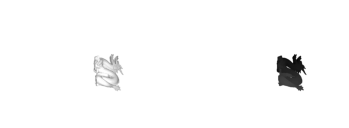

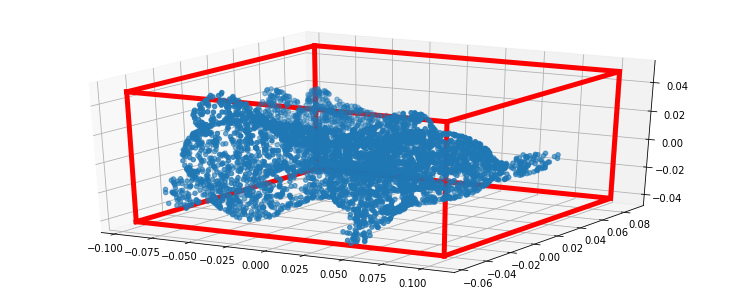

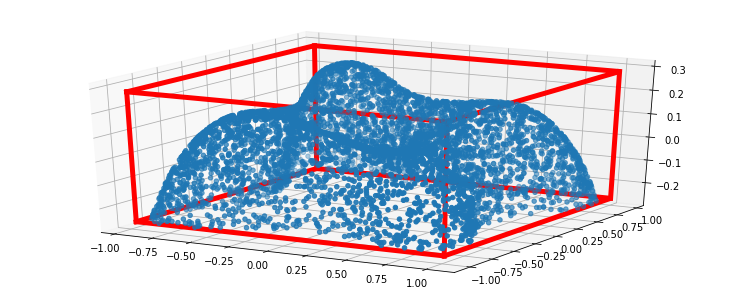

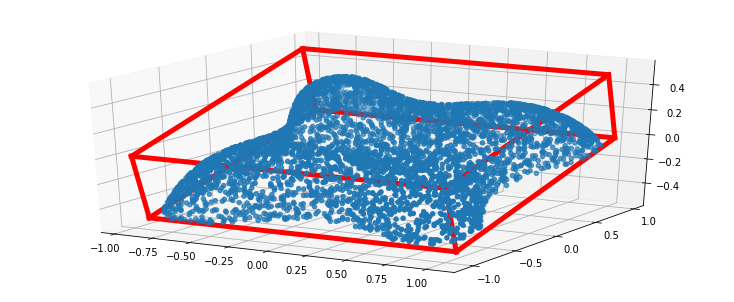

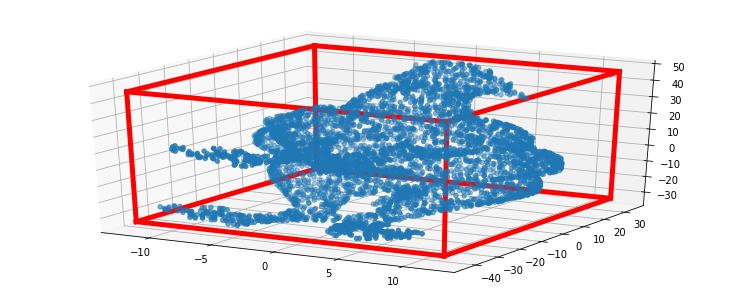

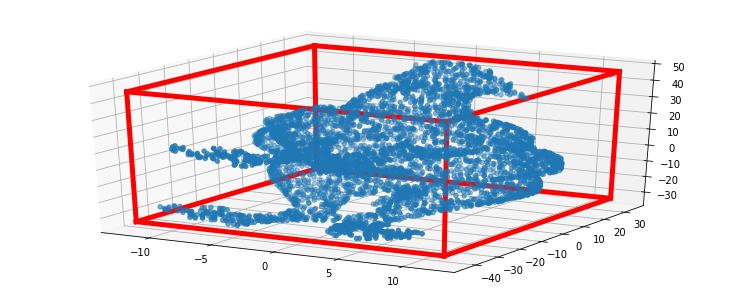

In [ ]:
def show_mesh(mesh): #FROM PYRENDEER WEBSITE
  mesh = pyrender.Mesh.from_trimesh(mesh)
  scene = pyrender.Scene()
  scene.add(mesh)

  # Set up the camera -- z-axis away from the scene, x-axis right, y-axis up
  camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0)
  s = np.sqrt(2)/2
  camera_pose = np.array([
        [0.0, -s,   s,   0.3],
        [1.0,  0.0, 0.0, 0.0],
        [0.0,  s,   s,   0.35],
        [0.0,  0.0, 0.0, 1.0],
      ])
  scene.add(camera, pose=camera_pose)

  # Set up the light -- a single spot light in the same spot as the camera
  light = pyrender.SpotLight(color=np.ones(3), intensity=3.0,
                                innerConeAngle=np.pi/16.0)
  scene.add(light, pose=camera_pose)

  # Render the scene
  r = pyrender.OffscreenRenderer(640, 480)
  color, depth = r.render(scene)

  # Show the images
  plt.figure()
  plt.subplot(1,2,1)
  plt.axis('off')
  plt.imshow(color)
  plt.subplot(1,2,2)
  plt.axis('off')
  plt.imshow(depth, cmap=plt.cm.gray_r)
  plt.show()

show_mesh(unique_meshes['dragon'])


def Plot_Mesh_Points_and_Bbox(mesh,bbox=None):
  #bbox inputted via flattened corners

  fig, (ax1, ax2) = plt.subplots(1, 2)


  ax1 = Axes3D(fig)
  fig.set_figwidth(10)
  ax1.scatter(mesh[:,0],mesh[:,1],mesh[:,2])
  if bbox is not None:
    bbox = bbox.reshape((8,3))
    
    #if we let matplotlib decide then the visual lines of the bbox will be wrong
    c = 'red'
    lw = 5

    #plot the bottom four corners first:
    ax1.plot(bbox[:4,0],bbox[:4,1],bbox[:4,2], c = c, linewidth=lw)

    #straight line linking the final point to the first (bottom)
    ax1.plot(bbox[(0,3),0],bbox[(0,3),1],bbox[(0,3),2], c = c, linewidth=lw)

    #then plot the top 4 corners
    ax1.plot(bbox[4:,0],bbox[4:,1],bbox[4:,2], c = c, linewidth=lw)

    #straight line linking the final point to the first (top)
    ax1.plot(bbox[(4,7),0],bbox[(4,7),1],bbox[(4,7),2], c = c, linewidth=lw)

    #plot the 4 lines connecting the bottom and top
    for i in range(4):
      ax1.plot(bbox[(i,i+4),0],bbox[(i,i+4),1],bbox[(i,i+4),2], c = c, linewidth=lw)
    


  ax1.view_init(elev=25.)

#Now we will plot some example clouds!

example_1_cloud = unique_clouds['dragon']
example_1_bbox = unique_bboxes['dragon']
Plot_Mesh_Points_and_Bbox(example_1_cloud,example_1_bbox)


example_2_cloud = cloud_dataset[amount_of_angles*3+amount_of_angles-1]
example_2_bbox = bbox_dataset[amount_of_angles*3+amount_of_angles-1]
Plot_Mesh_Points_and_Bbox(example_2_cloud,example_2_bbox)

example_3_cloud = cloud_dataset[amount_of_angles*3+2]
example_3_bbox = bbox_dataset[amount_of_angles*3+2]

Plot_Mesh_Points_and_Bbox(example_3_cloud,example_3_bbox)


example_4_cloud = validation_dataset[0]
example_4_bbox = validation_bbox_labels[0]
Plot_Mesh_Points_and_Bbox(example_4_cloud,example_4_bbox)

example_5_cloud = validation_dataset[amount_of_angles]
example_5_bbox = validation_bbox_labels[amount_of_angles]

Plot_Mesh_Points_and_Bbox(example_5_cloud,example_5_bbox)


Creating the PointNet

In [ ]:
class Final_Input_T_Layer(keras.layers.Layer):
    def __init__(self, units=3*3, input_dim=256):
        super(Final_Input_T_Layer, self).__init__()
        w_init = tf.zeros_initializer()
        self.w = tf.Variable(
            initial_value=w_init(shape=(input_dim, units), dtype="float32"), #weights are 256x9 matrix
            trainable=True,
        )
        b_init = tf.constant(np.eye(3,3).flatten(),dtype = "float32") #initial rotation is identity

        self.b = tf.Variable(
            initial_value=b_init, trainable=True
        )

    def call(self, inputs):
        return tf.reshape(tf.matmul(inputs, self.w) + self.b , (3,3))#return transformation matrix





class PointNet_Model(keras.Model):
  def __init__(self):
    super(PointNet_Model, self).__init__()
    self.batch_size = 64 #from the paper
    self.n = desired_point_number #derived from the data normalisation
    self.number_of_segments = 5

    self._Create_Point_Net_Layers()
    # self._Create_Tranformation_Net_Layers()




  def _Beginning_Segmentation_Layer_Func(self,x): 
    #this is a layer which manipluates the tensors such that we start the segmentation part of the model
    
    
    #we can use tiling to maxe this tensor into a longer repeating matrix.

    Max_Pool = x

    self.filling_matrix = K.tile(Max_Pool,[1,self.n,1,1])

    larger_matrix = K.concatenate((self.tensor_after_feature, self.filling_matrix), axis = 3) 
    #this is the matrix at the start of the segmentation section.

    return larger_matrix

  def _Input_Transformation_Function(self,x):
    #this is the function for the layer which comes after all of the t net layers
    #x = 256-long tensor


    #firstly, multiply by the external weights.
    weights_multiplied = K.dot(x,self.input_t_matrix_weights)

    #weights multiplied = 9-long tensor

    #Now add the external biases on.
    biases_added = K.bias_add(weights_multiplied,self.input_t_matrix_biases)

    #biases added = 9-long tensor
    transformation_matrix = K.reshape(biases_added,shape = (3,3))

    #this is now a 3x3 transformation matrix; transform the original input data
    #during the forward pass

    return transformation_matrix

  def _Feature_Transformation_Function(self,x):
    #x is 256-long tensor
    
    weights_multiplied = K.dot(x,self.feature_t_matrix_weights)

    #weights multiplied = 64-long tensor

    biases_added = K.bias_add(weights_multiplied,self.feature_t_matrix_biases)

    #biases added = 9-long tensor
    transformation_matrix = K.reshape(biases_added,shape = (64,64))

    #this is now a 64x64 transformation matrix; transform the original input data
    #during the forward pass

    return transformation_matrix


  def _Create_Tranformation_Net_Layers(self):
    self.input_t_net_1 = Conv2D(64,kernel_size = (1,1), activation = 'relu', name = "t_net_1")
    self.input_t_net_1_norm = BatchNormalization()

    self.input_t_net_2 = Conv2D(128,kernel_size = (1,1), activation = 'relu', name = "t_net_2")
    self.input_t_net_2_norm = BatchNormalization()

    self.input_t_net_3 = Conv2D(1024,kernel_size = (1,1), activation = 'relu', name = "t_net_3")
    self.input_t_net_3_norm = BatchNormalization()

    self.input_t_net_pool = MaxPooling2D(pool_size = (self.n, 1), name = "t_net_pool")
    self.input_t_net_pool_norm = BatchNormalization()

    self.input_t_net_4 = Dense(512, activation = 'relu', name = "t_net_4")
    self.input_t_net_4_norm = BatchNormalization()

    self.input_t_net_5 = Dense(256, activation = 'relu', name = "t_net_5")
    self.input_t_net_5_norm = BatchNormalization()

    self.final_in_t_layer = Final_Input_T_Layer()

  def _Create_Point_Net_Layers(self):

    """ 
    This function is just creating each and every layer object,
    these are individuals right now and become a graph in the 
    "call" function
    """


    #input dimensions is n x 3.
    #after this, we do a T-Net transform
    

    #Going to assume ReLu activation and Batch Normalization is present:
    

    self.expand_dims = Lambda(lambda z: tf.expand_dims(z,-2), name = "expand_dims_layer")
    # this allows for the x,y,z part of the points
    #to just have dimension length 1.


    self.first_output = Conv2D(64,kernel_size = (1,1), activation = 'relu', name = "first_output")
    self.first_norm = BatchNormalization()

    self.second_output = Conv2D(64,kernel_size = (1,1), activation = 'relu', name = "second_output")
    self.second_norm = BatchNormalization()

    """ 
    This is where the feature transformation (custom layer?? - Lambda function) should go!
    """
    # self.tensor_after_feature = self.second_norm #for use in a lambda function



    self.third_output = Conv2D(64,kernel_size = (1,1), activation = 'relu', name = "third_output")
    self.third_norm = BatchNormalization()

    self.fourth_output = Conv2D(128,kernel_size = (1,1), activation = 'relu', name = "fourth_output")
    self.fourth_norm = BatchNormalization()

    self.fifth_output = Conv2D(1024,kernel_size = (1,1), activation = 'relu', name = "fifth_output")
    self.fifth_norm = BatchNormalization()

    """
    now, similarly to the T-Net (since the T-Net is just a mini Point-Net)
    we pool all of the features, in thr shape of the input points. 
    """

    self.Max_Pool_Output = MaxPooling2D(pool_size = (self.n, 1))
    self.Max_Pool_Norm = BatchNormalization()

    #Now the system should be 1024 long - we must concatenate this onto
    #one of the previous layer's outputs, as shown in the diagram
    #this layer becomes repeated rows (until the amount of rows = n).

    self.start_of_segmentation = Lambda(self._Beginning_Segmentation_Layer_Func, name = "Custom_Aggregation_Layer")
    self.start_of_segmentation.trainable = False

    #Now we start the new sections of shared MLPs.

    self.first_segment_output = Conv2D(512,kernel_size = (1,1), activation = 'relu', name = "first_segment_output")
    self.first_segment_norm = BatchNormalization()

    self.second_segment_output = Conv2D(256,kernel_size = (1,1), activation = 'relu', name = "second_segment_output")
    self.second_segment_norm = BatchNormalization()

    self.third_segment_output = Conv2D(128,kernel_size = (1,1), activation = 'relu', name = "third_segment_output")
    self.third_segment_norm = BatchNormalization()
    

    #Now this is where the point features are (n x 128).
    #need to pool to regress bounding box points

    self.bbox_pool = MaxPooling2D(pool_size = (self.n, 1), name = 'Bounding_Box_Pool')
    self.bbox_pool_norm = BatchNormalization()
    #since the previous conv is 128, this is a 128 long tensor

    self.bbox_regress_1 = Dense(64, activation = 'relu', name = 'First_Bounding_Box_Regression')
    self.bbox_regress_1_norm = BatchNormalization()

    self.bbox_regress_2 = Dense(32, activation = 'relu', name = 'Second_Bounding_Box_Regression')
    self.bbox_regress_2_norm = BatchNormalization()

    self.bbox_output = Dense(8*3, name = 'Bounding_Box_Output')



  def call(self,inputs):
    """
    This function defines the model's/graph's forward pass.
    All of the layer objects are already defined
    and hence this layer is building them into a graph
    """

    new_inputs = self.expand_dims(inputs)

    #Start of input transformation net
    # x = self.input_t_net_1(self.new_inputs)
    # x = self.input_t_net_1_norm(x)
    # x = self.input_t_net_2(x)
    # x = self.input_t_net_2_norm(x)
    # x = self.input_t_net_3(x)
    # x = self.input_t_net_3_norm(x)
    # x = self.input_t_net_pool(x)
    # x = self.input_t_net_pool_norm(x)
    # x = self.input_t_net_4(x)
    # x = self.input_t_net_4_norm(x)
    # x = self.input_t_net_5(x)
    # x = self.input_t_net_5_norm(x)
    # self.small_transform_matrix  = self.final_in_t_layer(x) #output is 3x3 matrix
    # x = Lambda(lambda z: K.dot(self.new_inputs,z), name = "input_transform_multiplication")(self.small_transform_matrix)
    #End of input transformation net


    x = self.first_output(new_inputs)
    x = self.first_norm(x)
    x = self.second_output(x)
    x = self.second_norm(x)

    #Start of feature transformation net
    # x = self.feature_t_net_1(before_feature_transform)
    # x = self.feature_t_net_1_norm(x)
    # x = self.feature_t_net_2(x)
    # x = self.feature_t_net_2_norm(x)
    # x = self.feature_t_net_3(x)
    # x = self.feature_t_net_3_norm(x)
    # x = self.feature_t_net_pool(x)
    # x = self.feature_t_net_pool_norm(x)
    # x = self.feature_t_net_4(x)
    # x = self.feature_t_net_4_norm(x)
    # x = self.feature_t_net_5(x)
    # x = self.feature_t_net_5_norm(x)
    # large_transform_matrix = self.feature_transformation_matrix_layer(x) #output is 64x64 matrix
    # x = Lambda(lambda z: K.dot(before_feature_transform,z), name = "feature_transform_multiplication")(large_transform_matrix)
    #End of feature transformation net

    self.tensor_after_feature = x #necessary to use later during the custom layer
    x = self.third_output(x)
    x = self.third_norm(x)
    x = self.fourth_output(x)
    x = self.fourth_norm(x)
    x = self.fifth_output(x)
    x = self.fifth_norm(x)
    x = self.Max_Pool_Output(x)
    x = self.Max_Pool_Norm(x)
    x = self.start_of_segmentation(x) #custom layer
    x = self.first_segment_output(x)
    x = self.first_segment_norm(x)
    x = self.second_segment_output(x)
    x = self.second_segment_norm(x)
    x = self.third_segment_output(x)
    x = self.third_segment_norm(x)

    x = self.bbox_pool(x)
    x = self.bbox_pool_norm(x)

    x = self.bbox_regress_1(x)
    x = self.bbox_regress_1_norm(x)

    x = self.bbox_regress_2(x)
    x = self.bbox_regress_2_norm(x)

    x = self.bbox_output(x)

    return x 



  

Compiling and Testing the Network with an Example

In [ ]:
PointNet = PointNet_Model()
input_layer = keras.layers.Input(shape = (PointNet.n,6))


# PointNet.call(input_layer)

Adam_Optimiser = keras.optimizers.Adam(lr = 0.001) #initial
# loss_type = keras.losses.CategoricalCrossentropy(from_logits = True)
PointNet.compile(optimizer = Adam_Optimiser, loss = 'mse')
#need to put "from logits = True" in above ??

print(PointNet.n)
example_point = cloud_dataset[0]
example_point = np.array(example_point).reshape((1,PointNet.n,6))


print("example point",example_point.shape)


example_prediction = PointNet.predict(example_point)
print("example prediction",example_prediction)
print("example prediction shape",example_prediction.shape)
PointNet.summary()
print(example_prediction[0][0].shape)
# print(PointNet.x)



5000
example point (1, 5000, 6)
example prediction [[[[ 2.0929300e-03  5.2834558e-03 -1.6664427e-02 -1.7333960e-02
    -1.2171056e-02  1.8275503e-02  1.9390037e-02  3.2024290e-02
     1.3913391e-02 -1.0356968e-02  1.2274623e-02  1.1168244e-02
    -4.0608416e-03  3.1343377e-03  3.0046148e-02 -1.7561605e-02
     6.4831642e-03 -2.5561988e-02  3.1959612e-02 -1.0444975e-02
    -3.1505693e-02 -9.8211644e-03 -3.4851277e-05 -3.7389428e-03]]]]
example prediction shape (1, 1, 1, 24)
Model: "pointnet_model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
expand_dims_layer (Lambda)   (None, 5000, 1, 6)        0         
_________________________________________________________________
first_output (Conv2D)        (None, 5000, 1, 64)       448       
_________________________________________________________________
batch_normalization_25 (Batc (None, 5000, 1, 64)       256       
__________________________________

# Training the Network

In [ ]:
history = PointNet.fit(cloud_dataset,
                       bbox_dataset,
                       batch_size = PointNet.batch_size,
                       epochs = 200,
                       verbose = 1,
                       validation_data=(validation_dataset, validation_bbox_labels))

Train on 1650 samples, validate on 150 samples
Epoch 1/200
1650/1650 [==============================] - 1334s 808ms/step - loss: 602.4756 - val_loss: 1092.0258
Epoch 2/200
1650/1650 [==============================] - 1149s 697ms/step - loss: 601.9742 - val_loss: 1090.9099
Epoch 3/200
1650/1650 [==============================] - 1165s 706ms/step - loss: 601.6858 - val_loss: 1092.5706
Epoch 4/200
1650/1650 [==============================] - 1225s 742ms/step - loss: 601.2670 - val_loss: 1092.2589
Epoch 5/200
1650/1650 [==============================] - 1163s 705ms/step - loss: 600.7104 - val_loss: 1091.4262
Epoch 6/200
1650/1650 [==============================] - 1173s 711ms/step - loss: 599.9528 - val_loss: 1086.9377
Epoch 7/200
1650/1650 [==============================] - 1146s 694ms/step - loss: 599.0837 - val_loss: 1083.4398
Epoch 8/200
1650/1650 [==============================] - 1135s 688ms/step - loss: 598.1147 - val_loss: 1079.5600
Epoch 9/200
1650/1650 [==========================

KeyboardInterrupt: ignored

# Evaluate Results

[[ 0.74484718  0.83249503 -0.06107471  0.08365991  0.82289903  0.56199485]
 [ 0.56588299 -0.89233753 -0.15845296 -0.25506295 -0.8324197   0.49195562]
 [ 0.11764509  0.58484284  0.04234143 -0.10930817  0.82958148  0.54758223]
 ...
 [-0.90459196  0.77576026 -0.24738611 -0.94616993  0.10165866  0.30729136]
 [ 0.50450005 -0.46587519  0.05441878 -0.0035967   0.01556425  0.9998724 ]
 [-0.82214356  0.55262744 -0.04469366 -0.90795057 -0.22576551  0.35306614]]
(5000, 6)


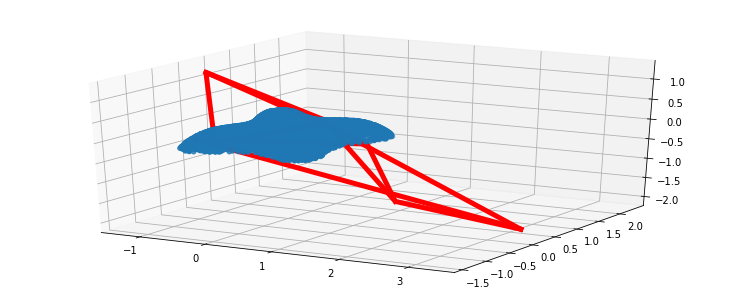

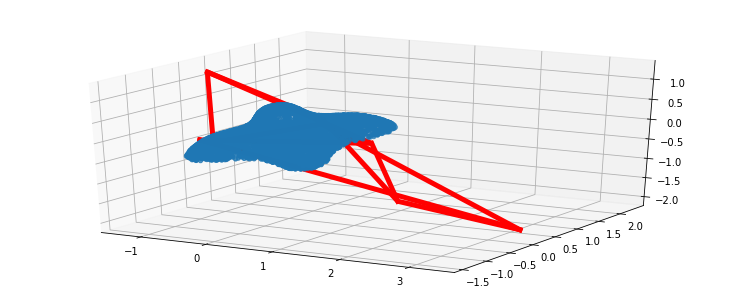

In [ ]:
#saved results below are not the best that the system can do - it needs to train more

example_1_cloud = cloud_dataset[amount_of_angles*3+amount_of_angles-1]
example_2_cloud = cloud_dataset[amount_of_angles*3+2]


example_1_cloud_reshape = np.array((cloud_dataset[amount_of_angles*3+amount_of_angles-1])).reshape((1,PointNet.n,6))
example_2_cloud_reshape = np.array((cloud_dataset[amount_of_angles*3+2])).reshape((1,PointNet.n,6))

print(example_1_cloud)
print(example_1_cloud.shape)

predicted_bbox_1 = PointNet.predict(example_1_cloud_reshape)
predicted_bbox_2 = PointNet.predict(example_2_cloud_reshape)

Plot_Mesh_Points_and_Bbox(example_1_cloud,predicted_bbox_1)
Plot_Mesh_Points_and_Bbox(example_2_cloud,predicted_bbox_2)


